_(tv) 2021-11-21, 2023-12-11_

# Generate Uniform Distribution on the Sphere

In [42]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy

In [11]:
rng = np.random.default_rng()

In [200]:
N = 5000 # number of points to sample

In [285]:
def to_cartesian(r, phi, theta):
    ''' helper function to convert from spherical to cartesian coordinates '''
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x,y,z

We first demonstrate the "problem": just representing points in spherical coordinates with the two angles (phi,theta) and drawing randomly the two angles from uniform distributions is _not_ the right thing to do.
Instead, one needs to account for the volume element of the spherical coordinates and draw accordingly for theta.

In [202]:
def uniform_angles(N):
    phi = rng.random(N)*2*np.pi
    theta = rng.random(N)*np.pi
    return to_cartesian(1,phi,theta)

In [203]:
def non_uniform_angles(N):
    phi = rng.random(N)*2*np.pi
    theta = 2*np.arcsin(np.sqrt(rng.random(N)))
    return to_cartesian(1,phi,theta)

In the plot one should be able to see that on the left (uniformly drawn angles), the points accumulate somewhat towards the North and South pole. To the right (correctly drawn angles) this effect should have gone away.

<IPython.core.display.Javascript object>


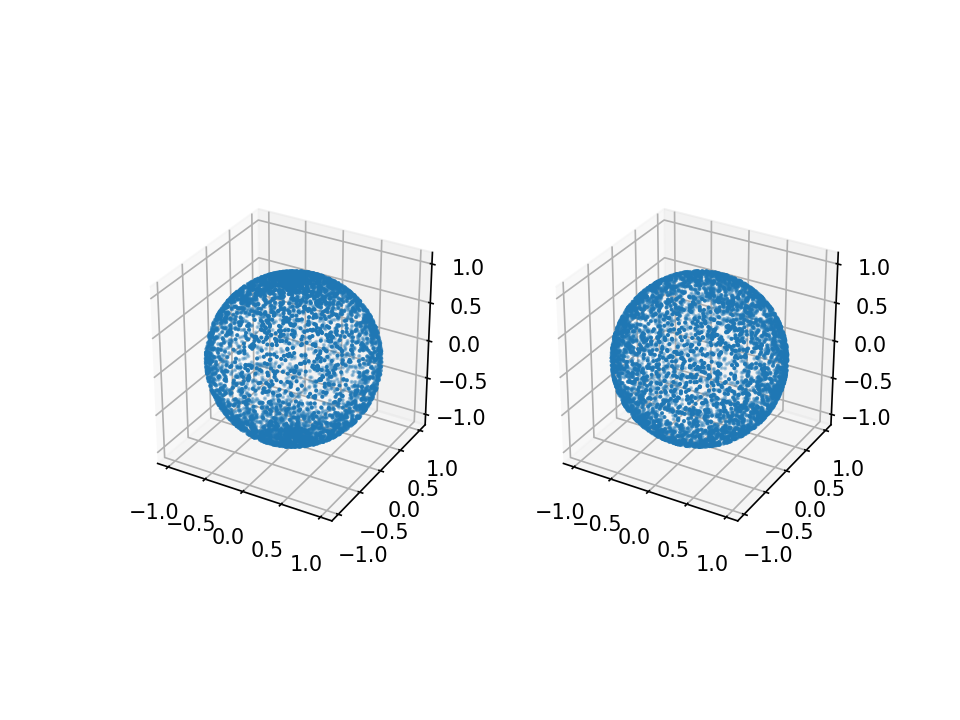

In [208]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d', box_aspect=(1,1,1))
x,y,z = uniform_angles(N)
ax.scatter(x,y,z,s=1)
ax = fig.add_subplot(122, projection='3d', box_aspect=(1,1,1))
x,y,z = non_uniform_angles(N)
ax.scatter(x,y,z,s=1)
plt.show()

Since evaluating the arcsin for every point is costly, a numerically equally acceptable method is to just draw three normal-distributed random numbers and normalize the resulting vectors. The resulting distribution is by construction homogeneous.

In [263]:
def sph_gaussian(N):
    v = rng.standard_normal((3,N))
    v = v / (np.linalg.norm(v,axis=0))
    return *v, # unpack into 3-tuple of arrays x,y,z

<IPython.core.display.Javascript object>


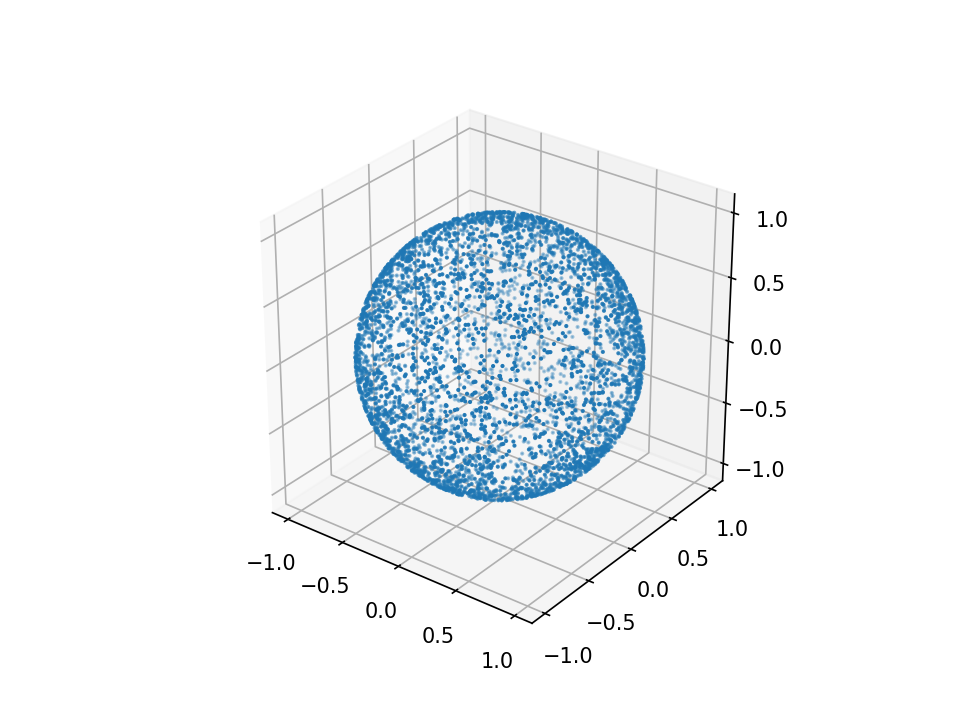

In [265]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
x,y,z = sph_gaussian(N)
ax.scatter(x,y,z,s=1)
plt.show()

Another method that does not even require to draw from a non-uniform distribution is just to draw uniformly distributed vectors in the cube enclosing the sphere, discard everything that is outside the sphere, and take the normalized remainders. The drawback is that this throws away quite a few points (in fact, since the volume of the cube is 8 and that of the sphere is 4pi/3, around 48% of all points... - recall how to calculate pi with Monte Carlo simulations?)

In [296]:
def throwaway(N):
    v = rng.random(size=(3,N))*2-1
    vnorm = np.linalg.norm(v,axis=0)
    keep = vnorm<=1.0
    v = v[:,keep]
    kept = v.shape[-1]
    print ("{}/{} ({:.2f}%) points survived".format(kept,N,kept/N*100))
    print ("estimate of pi is thus {}".format(kept/N*6))
    #v = v / np.linalg.norm(v,axis=0)
    v = v / vnorm[keep]
    return *v,

<IPython.core.display.Javascript object>


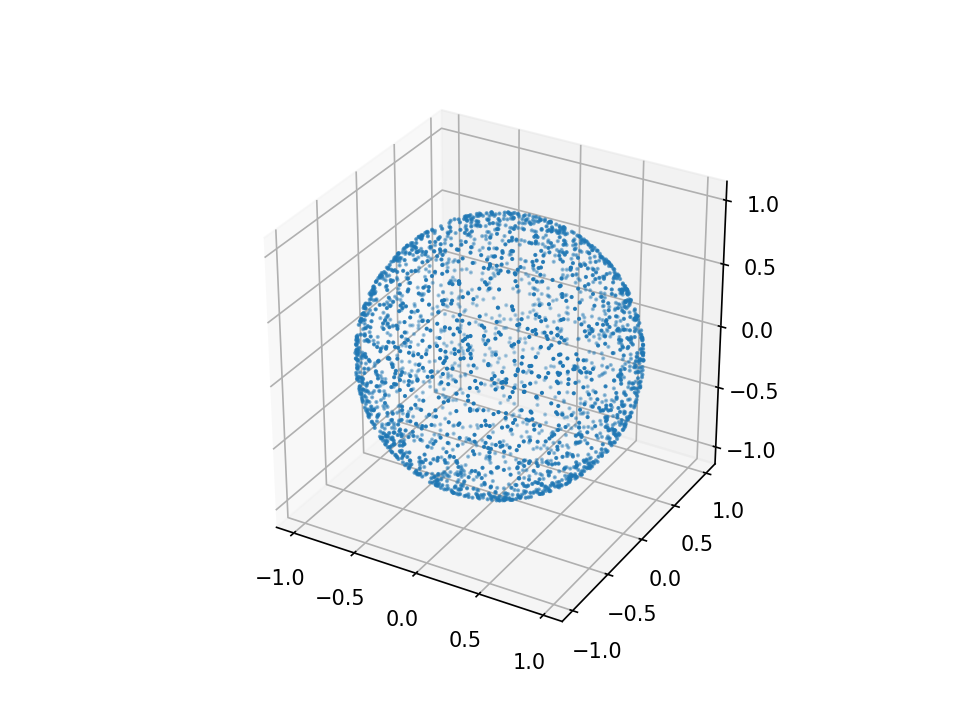

2580/5000 (51.60%) points survived
estimate of pi is thus 3.096


In [300]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
x,y,z = throwaway(N)
ax.scatter(x,y,z,s=1)
plt.show()